# Advanced Azure Data Analytics Day : Azure Synapse Analytics Training For Game Industry


- ## Churn Prediction Using Azure Synapse Analytics
- ## Step 2. Apache Spark Machine Learning Model 


# 1. Import Library


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 2. Load Dataset


In [3]:
# WoW_Churn_Data(wow 게임 이탈 사용자 데이터, 가공 데이터)
df = spark.read.load('abfss://aaafilesystem@aaatraing.dfs.core.windows.net/sparkpooldata/churnersdf_yj3.csv', format='csv', header=True)

# 3. Preprocess Data
- ## WoW_Churn Dataset Review

- Attribute Information:
- IdentifierId : continuous (7~78572)
- log_timestamp : timestamp (2008-01-01, 2008-09-28)
- level : continuous (1~70)
- race : categorical (Blood Elf, Undead, Tauren, Troll, Orc )
- charclass : categorical (Hunter, Mage, Warlock, Warrior, Paladin 외 4개)
- guild : continuous (-1~450)
- zoneId : categorical ('Ahn'Qiraj, Alterac Mountains, Alterac Valley, Arathi Basin, Arathi Highlands 외 121개)
- Continent : categorical (Eastern Kingdoms, Kalimdor, Northrend, Otherr, Ouland 외 2개)
- Area : categorical (null, Azeroth, Central Kalimdor, Khaz Modan, Lordaeron 외 6개)
- Zone : null, Ahn'Qiraj, Alterac Mountains, Arathi Highlands, Ashenvale 외 60개)
- Subzone : null, Ahn'Qiraj, Alterac Mountains, Auchindoun, Caer Darrow 외 23개)
- Type : categorical (Arena, Battleground, City, Dungeon, Event 외 3개)
- Size : continuous (0~40)
- Controlled : categorical (Contested, Horde, Sanctuary, PvP, Alliance)
- Min_req_level : continuous (1~70)
- Min_rec_level : continuous (0~70)
- Max_rec_level : continuous (0~100)
- Min_bot_level : continuous (0~70)
- Max_bot_level : continuous (0~100)
- churn_timestamp : timestamp (2008-01-01, 2008-09-27  
- churn : Target/Label (FALSE, TRUE)

- ## 3.1 Replace value


In [4]:
df = df.withColumn('churn', regexp_replace('churn', 'FALSE', '0')).withColumn('churn', regexp_replace('churn', 'TRUE', '1'))

- ## 3.2 Convert Dataype


In [6]:
df1=df.withColumn('level', col('level').cast(IntegerType()))\
      .withColumn('Size', col('Size').cast(IntegerType()))\
      .withColumn('Min_req_level', col('Min_req_level').cast(IntegerType()))\
      .withColumn('Min_rec_level', col('Min_rec_level').cast(IntegerType()))\
      .withColumn('Max_rec_level', col('Max_rec_level').cast(IntegerType()))\
      .withColumn('Min_bot_level', col('Min_bot_level').cast(IntegerType()))\
      .withColumn('Max_bot_level', col('Max_bot_level').cast(IntegerType()))\
      .withColumn('churn', col('churn').cast(IntegerType()))

df2= df1.withColumn('churn_timestamp', to_timestamp(unix_timestamp(col('churn_timestamp'), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")))

df3= df2.withColumn('log_timestamp', to_timestamp(unix_timestamp(col('log_timestamp'), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")))

In [7]:
df3 = df3.withColumn('weekday_num', date_format('churn_timestamp', 'u')).withColumn('weekday', date_format('churn_timestamp', 'E'))
df4 = df3.withColumn('weekday_num', col('weekday_num').cast(IntegerType()))

In [8]:
print(df4.printSchema())

root
 |-- IdentifierId: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- charclass: string (nullable = true)
 |-- zoneId: string (nullable = true)
 |-- guild: string (nullable = true)
 |-- log_timestamp: timestamp (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- Subzone: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Controlled: string (nullable = true)
 |-- Min_req_level: integer (nullable = true)
 |-- Min_rec_level: integer (nullable = true)
 |-- Max_rec_level: integer (nullable = true)
 |-- Min_bot_level: integer (nullable = true)
 |-- Max_bot_level: integer (nullable = true)
 |-- churn_timestamp: timestamp (nullable = true)
 |-- churn: integer (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- weekday: string (nullable = true)

None

- ## 3.3 Sampling Data

In [9]:
sampled_df = df4.sample(True, 0.0025, seed=1234)
print(sampled_df.count()) #21,549

21549

In [10]:
display(sampled_df.groupBy('churn').count())

# 4. Transform the Feature Data
- ## 4.1 Category Indexing & One-Hot Encoding
- 'IdentifierId', 'zoneId','guild' 
- 'race', 'charclass', 'Continent', 'Area', 'Zone', 'Subzone', 'Type',  'Controlled', 'weekday'
- 'log_timestamp','churn_timestamp'
- 'level','Size', 'Min_req_level', 'Min_rec_level', 'Max_rec_level', 'Min_bot_level', 'Max_bot_level','weekday_num', 
- 'churn'

In [12]:
# Because the sample uses an algorithm that works only with numeric features, convert them so they can be consumed
sI1 = StringIndexer(inputCol="race", outputCol="raceIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="raceIndex", outputCol="raceVec")
sI2 = StringIndexer(inputCol="charclass", outputCol="charclassIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="charclassIndex", outputCol="charclassVec")
sI3 = StringIndexer(inputCol="Continent", outputCol="ContinentIndex")
en3 = OneHotEncoder(dropLast=False, inputCol="ContinentIndex", outputCol="ContinentVec")
#'Area'
#'Type'
#'Controlled'

# Create a new DataFrame that has had the encodings applied
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3]).fit(sampled_df).transform(sampled_df)

In [13]:
encoded_final_df.printSchema()

root
 |-- IdentifierId: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- charclass: string (nullable = true)
 |-- zoneId: string (nullable = true)
 |-- guild: string (nullable = true)
 |-- log_timestamp: timestamp (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- Subzone: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Controlled: string (nullable = true)
 |-- Min_req_level: integer (nullable = true)
 |-- Min_rec_level: integer (nullable = true)
 |-- Max_rec_level: integer (nullable = true)
 |-- Min_bot_level: integer (nullable = true)
 |-- Max_bot_level: integer (nullable = true)
 |-- churn_timestamp: timestamp (nullable = true)
 |-- churn: integer (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- raceIndex: double (nullable = false)
 |-

- ## 4.2 Convert Pandas DataFrame


In [14]:
pd_df=encoded_final_df.toPandas() #Spark DataFrame → #Pandas DataFrame

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:2110: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

In [ ]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)
pd_df.describe()

- 'IdentifierId', 'zoneId','guild', 'Controlled', 
- 'race', 'charclass', 'Continent', 'Area', 'Zone', 'Subzone', 'Type', 'weekday'
- 'log_timestamp','churn_timestamp'
- 'level','Size', 'Min_req_level', 'Min_rec_level', 'Max_rec_level', 'Min_bot_level', 'Max_bot_level','weekday_num', 
- 'churn'


In [16]:
pd_df_num=pd_df[['level','Size', 'Min_req_level', 'Min_rec_level', 'Max_rec_level', 'Min_bot_level', 'Max_bot_level','weekday_num', 'raceIndex','charclassIndex','ContinentIndex','churn']]

- ## 4.3 Data visualization


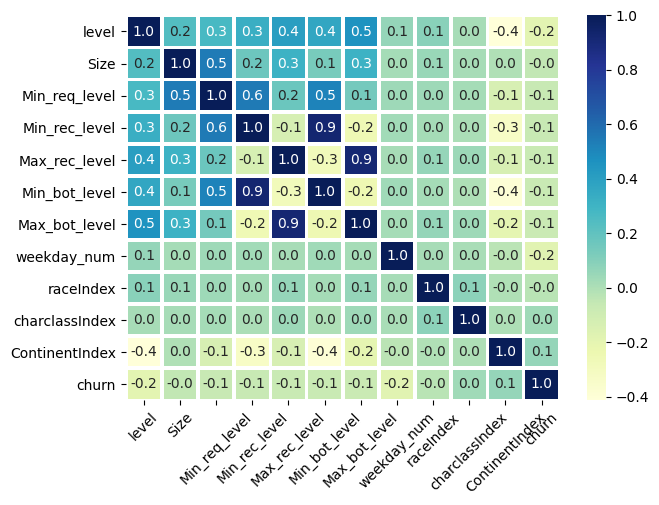

In [17]:
plt.rcParams["figure.figsize"] = [7, 5]
heat_map = sns.heatmap(pd_df_num.corr(method='pearson'), annot=True, fmt='.1f', linewidths=2, cmap='YlGnBu')
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);
plt.show()

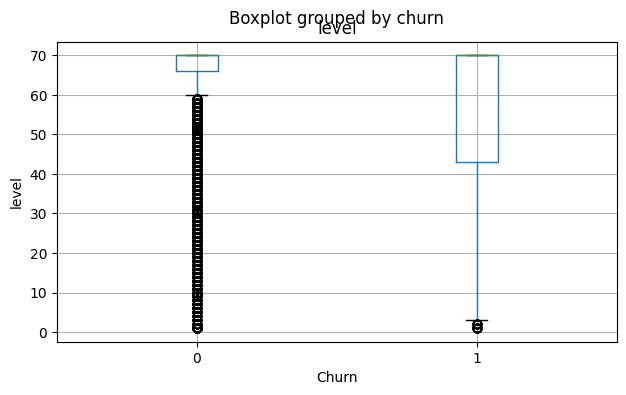

In [23]:
# How many passengers tipped by various amounts 
plt.rcParams["figure.figsize"] = [7, 4]
ax = pd_df_num.boxplot(column=['level'], by=['churn'])
#ax.set_title('Churn by level \n')
ax.set_xlabel('Churn')
ax.set_ylabel('level')
plt.show()

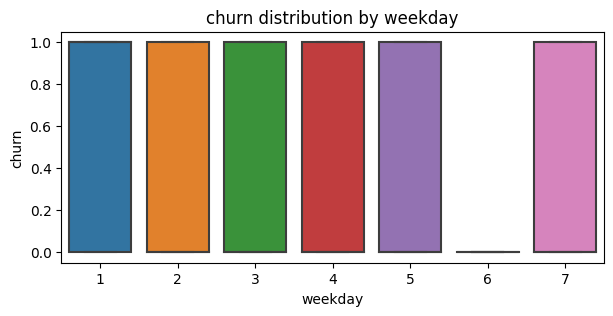

In [22]:
plt.rcParams["figure.figsize"] = [7, 3]
ax = sns.boxplot(x="weekday_num", y="churn",data=pd_df_num, showfliers = False)
ax.set_title('churn distribution by weekday')
ax.set_xlabel('weekday')
ax.set_ylabel('churn')
plt.show()

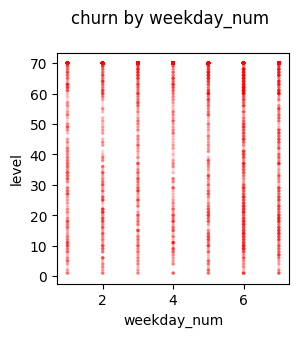

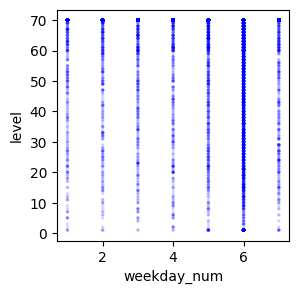

In [19]:
# Look at the relationship between fare and tip amounts
plt.rcParams["figure.figsize"] = [3, 3]
ax1 = pd_df_num.plot(kind='scatter', x= 'weekday_num', y = 'level', c='red', alpha = 0.10, s=2.5*(pd_df_num['churn']==1))
ax2 = pd_df_num.plot(kind='scatter', x= 'weekday_num', y = 'level', c='blue', alpha = 0.10, s=2.5*(pd_df_num['churn']==0))
ax1.set_title('churn by weekday_num \n')
ax1.set_xlabel('weekday_num')
ax1.set_ylabel('level')
plt.show(ax1,ax2)

# 5. Train a logistic regression model
- ## 5.1 Split training and testing data sets
- 70% of the data is used to train the model.
- 30% of the data is used to test the model. 

In [28]:
# trainingFraction, testingFraction = (1-trainingFraction), seed
train_df, test_df = encoded_final_df.randomSplit([0.7, 0.3], 1234)

In [31]:
## Create a new logistic regression object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'churn')

## The formula for the model
classFormula = RFormula(formula='churn ~ level +  race +  charclass +  Continent + Type +  Size +  Controlled +  Min_req_level +  Min_rec_level + \
 Max_rec_level +  Min_bot_level +  Max_bot_level +  weekday_num + raceVec +  charclassVec + ContinentVec')

## Undertake training and create a logistic regression model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_df)

## Saving the model is optional, but it's another form of inter-session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "wow_lrModel_" + datestamp
logRegDirfilename = fileName
lrModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset; evaluation using area under ROC
predictions = lrModel.transform(test_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6787525201612903

# 6. Create a visual representation of the prediction

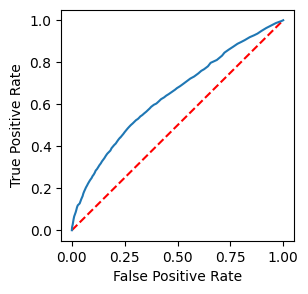

In [33]:
## Plot the ROC curve; no need for pandas, because this uses the modelSummary object
plt.rcParams["figure.figsize"] = [3, 3]
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# 7. Shut down the Spark instance
After you finish running the application, shut down the notebook to release the resources by closing the tab. Or select End Session from the status panel at the bottom of the notebook.
